# RoC Analysis Random Forest

## Data Generation
* Fix a beta* value and number of predictors
* Create a Y vector using Bernoulli distribution for logit
* Create a X vector using normal distribution as i.i.ds

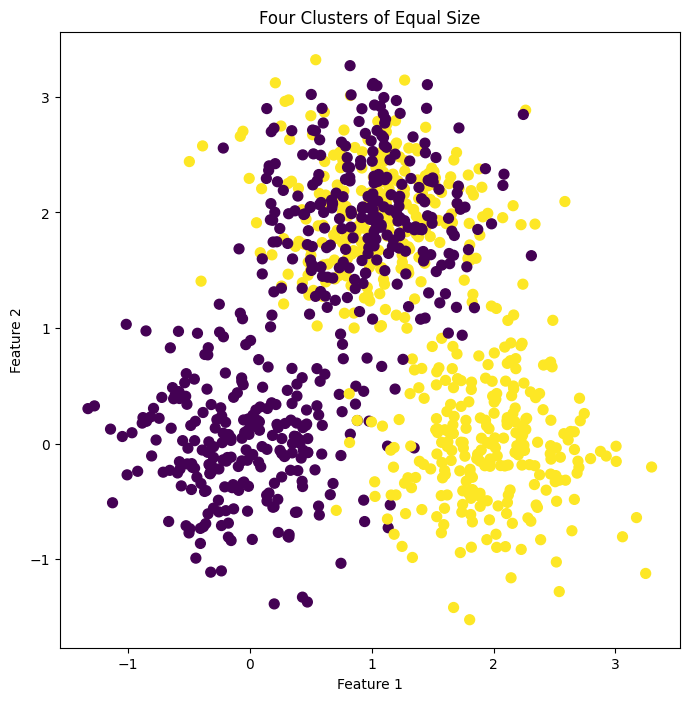

Training data shape: (800, 2), (800,)
Test data shape: (200, 2), (200,)


In [1]:
no_predictors = 2
no_samples = 1000
no_classes = 2
#kerneltype = 'linear'  #comment out for polynomial kernel
#kerneltype = 'poly'  #comment out for linear kernel

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

n_samples_per_cluster = 250
n_clusters = 4

# Create the clusters deterministically
np.random.seed(0) # for reproducibility

X = np.zeros((n_samples_per_cluster * n_clusters, 2))
y = np.zeros(n_samples_per_cluster * n_clusters)

# Cluster centers in corners of a square
centers = [[0, 0], [2, 0], [1, 2], [1, 2]]

# Assign points to clusters deterministically
for i in range(n_clusters):
    cluster_indices = slice(i * n_samples_per_cluster, (i + 1) * n_samples_per_cluster)
    X[cluster_indices] = centers[i] + np.random.normal(scale=0.5, size=(n_samples_per_cluster, 2))
    if i == 0 or i == 3:
        y[cluster_indices] = 0
    else:
        y[cluster_indices] = 1



#Visualize
plt.figure(figsize=(8,8))
plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', s=50)
plt.title('Four Clusters of Equal Size')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

#add intercept to X
#X = np.hstack((np.ones((X.shape[0], 1)), X))

# # shuffle data
# permutation = np.random.permutation(no_samples)
# X = X[permutation]
# y = y[permutation]


#Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}, {y_train.shape}")
print(f"Test data shape: {X_test.shape}, {y_test.shape}")





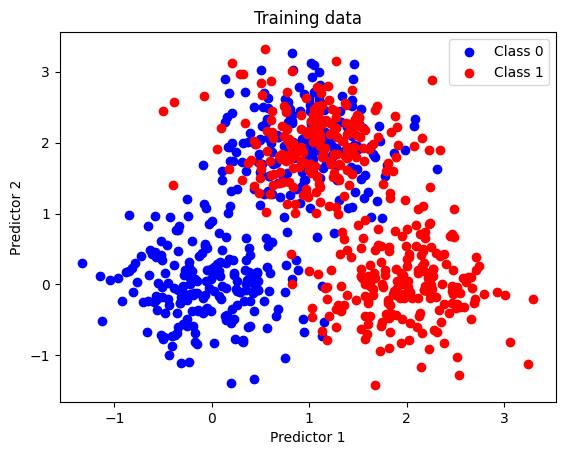

In [2]:
plt.figure()
plt.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], color='b', label='Class 0') 
plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], color='r', label='Class 1') 
plt.xlabel('Predictor 1') 
plt.ylabel('Predictor 2') 
plt.legend()
plt.title('Training data')
plt.show()

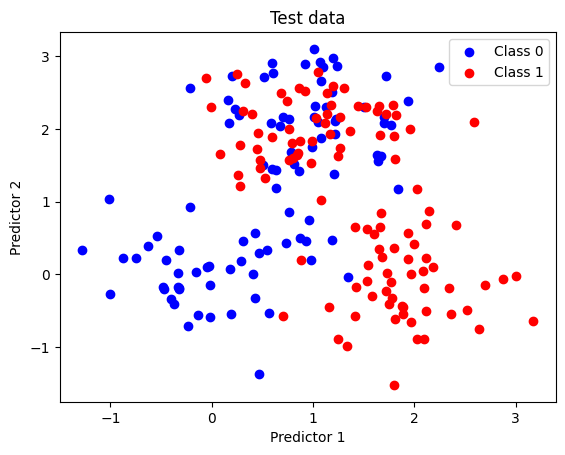

In [3]:
plt.figure()
plt.scatter(X_test[y_test == 0, 0], X_test[y_test == 0, 1], color='b', label='Class 0') 
plt.scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1], color='r', label='Class 1') 
plt.xlabel('Predictor 1') 
plt.ylabel('Predictor 2') 
plt.legend()
plt.title('Test data')
plt.show()

## Random Forest based classifier

In [4]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(class_weight='balanced', random_state=42)
clf.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', random_state=42)

## Standard RoC curve

Length of threshold prc 74
Length of threshold_roc 66


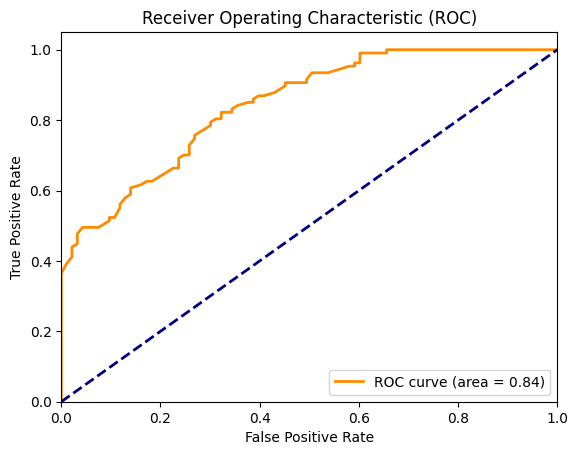

In [5]:
# Plot the RoC curve
from sklearn.metrics import roc_curve, precision_recall_curve, auc
fpr_roc, tpr_roc, threshold_roc = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
precision_prc, recall_prc, threshold_prc = precision_recall_curve(y_test, clf.predict_proba(X_test)[:, 1])

print("Length of threshold prc", len(threshold_prc))
print("Length of threshold_roc", len(threshold_roc))

roc_auc = auc(fpr_roc, tpr_roc)

# Plot the ROC curve
plt.figure()
plt.plot(fpr_roc, tpr_roc, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line representing random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


## RoC curve by cost-sensitive learning

The following function fixes the threshold value. The input model to the function will be weighted in order to have the bias towards the minority class

In [6]:
import numpy as np
from sklearn.metrics import confusion_matrix

def get_fpr_tpr(clf_model, X_test, y_test):
    """
    Calculates the False Positive Rate (FPR) and True Positive Rate (TPR) at a given threshold.

    Args:
        X_test: The test features.
        y_test: The true test labels (0 or 1).
        threshold: The probability threshold.

    Returns:
        A dictionary containing the FPR and TPR. Returns None if there's an error.
    """
    try:
        y_pred = clf_model.predict(X_test) # predict directly

        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  #Avoid division by zero
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0 #Avoid division by zero
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        misclassification_rate = 1 - accuracy

        return {"fpr": fpr, "tpr": tpr, "precision": precision, "recall": recall, "f1": f1, "accuracy": accuracy, "misclassification_rate": misclassification_rate}

    except ValueError as e:
        print(f"Error calculating FPR and TPR: {e}")
        return None





Class1_final 407000, w 0.001
Class1_final 354234, w 0.0011489576925129044
Class1_final 308309, w 0.0013201037791845764
Class1_final 268338, w 0.0015167433920094757
Class1_final 233549, w 0.0017426739878174011
Class1_final 203270, w 0.0020022586838449427
Class1_final 176917, w 0.002300510517204408
Class1_final 153980, w 0.002643189255448845
Class1_final 134017, w 0.003036912627815404
Class1_final 116642, w 0.0034892841252180872
Class1_final 101520, w 0.004009039837032482
Class1_final 88358, w 0.004606217160349146
Class1_final 76903, w 0.005292348639768098
Class1_final 66933, w 0.0060806846811217565
Class1_final 58255, w 0.00698644944012022
Class1_final 50703, w 0.008027134827578601
Class1_final 44129, w 0.009222838308984672
Class1_final 38408, w 0.01059665102191064
Class1_final 33428, w 0.012175103706498954
Class1_final 29094, w 0.013988679060724341
Class1_final 25322, w 0.016072400414913413
Class1_final 22039, w 0.018466508093862365
Class1_final 19182, w 0.021217236528294964
Class1_fin

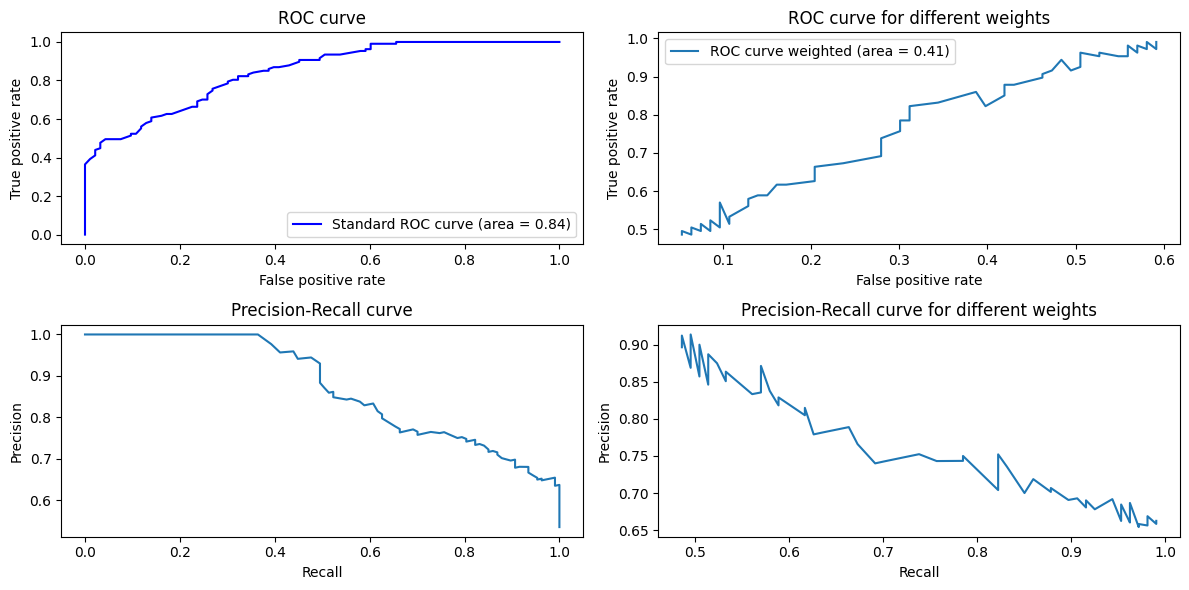

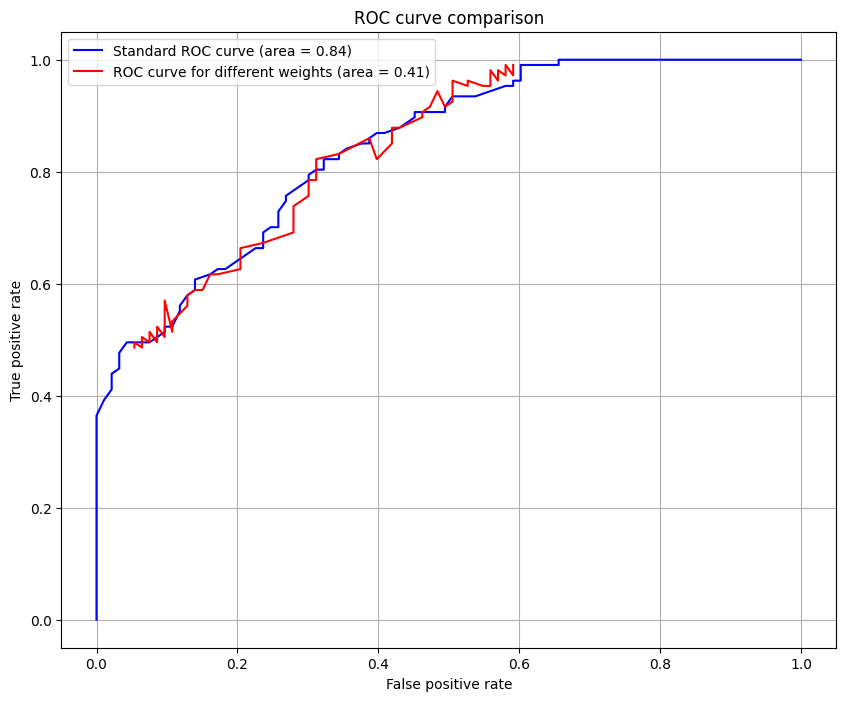

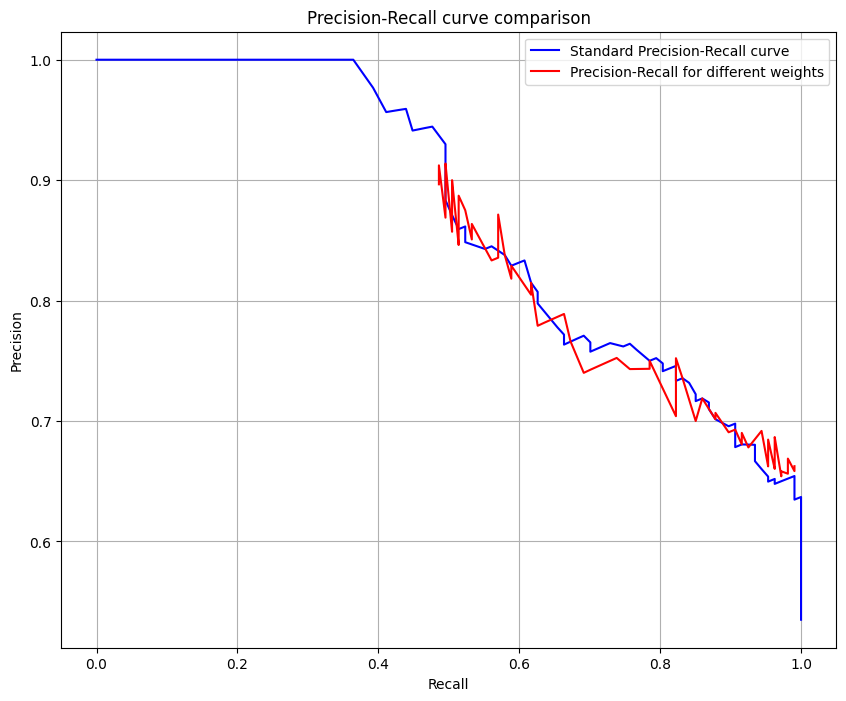

In [7]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# count the class 0 and class 1 samples in y_train
counter = Counter(y_train)
Class0_initial = counter[0]
Class1_initial = counter[1]

# Weight the X_train and y_train for cost-sensitive learning
class_ratio = Class0_initial / Class1_initial
#alpha_target = np.arange(class_ratio-0.99, class_ratio+0.99, 0.01)

# Define the number of points below and above the class_ratio
# You can adjust these to control the density of points
num_points_below = 50
num_points_above = 50
class_ratio_low = 0.001  # Minimum value for class_ratio
class_ratio_high = 1000.0  # Maximum value for class_ratio

# Generate points below class_ratio with smaller increments
# Using geomspace for a geometric progression
if class_ratio > class_ratio_low:
    alpha_below = np.geomspace(class_ratio_low, class_ratio, num_points_below, endpoint=False)
else:
    alpha_below = np.array([]) # Handle cases where class_ratio is very small

# Generate points above class_ratio with larger, geometric increments
if class_ratio < class_ratio_high:
    alpha_above = np.geomspace(class_ratio, class_ratio_high, num_points_above)
else:
    # If class_ratio is already >= 1000, we might just want 1000 or an empty array
    alpha_above = np.array([class_ratio_high]) if class_ratio == class_ratio_high else (np.array([]) if class_ratio > class_ratio_high else np.geomspace(class_ratio, class_ratio_high, num_points_above))


# Combine the arrays and remove duplicates (especially class_ratio itself)
alpha_target = np.unique(np.concatenate((alpha_below, alpha_above)))

dict_weighted_clfs = {}
for w in alpha_target:
    
    # calculate the class weights
    if w >= class_ratio:
        Class0_final = int(Class1_initial * w)
        print(f"Class0_final {Class0_final}, w {w}")
        if Class0_final < Class0_initial:
            print(f"Class0_final {Class0_final} is less than Class0_initial {Class0_initial}")
        sampling_strategy_dict = {0: Class0_final}
    elif w < class_ratio:
        Class1_final = int(Class0_initial / w)
        print(f"Class1_final {Class1_final}, w {w}")
        if Class1_final < Class1_initial:
            print(f"Class1_final {Class1_final} is less than Class1_initial {Class1_initial}")
        sampling_strategy_dict = {1: Class1_final}

    smote = SMOTE(sampling_strategy=sampling_strategy_dict, random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
    # Fit the Random Forest classifier with the resampled data
    clf_weighted = RandomForestClassifier(random_state=42)
    clf_weighted.fit(X_resampled, y_resampled)

    res = get_fpr_tpr(clf_weighted, X_test, y_test)
    dict_weighted_clfs[w] = {
        "model": clf_weighted,
        "fpr": res["fpr"],
        "tpr": res["tpr"],
        "precision": res["precision"],
        "recall": res["recall"],
        "f1": res["f1"],
        "accuracy": res["accuracy"],
        "misclassification_rate": res["misclassification_rate"]
    }
    #print(f"Weight: {w:.2f}, FPR: {res['fpr']:.3f}, TPR: {res['tpr']:.3f}")

# Extract and sort FPR and TPR values from the weighted classifiers
fpr_weighted = [v["fpr"] for v in dict_weighted_clfs.values()]
tpr_weighted = [v["tpr"] for v in dict_weighted_clfs.values()]
roc_points = sorted(zip(fpr_weighted, tpr_weighted))
fpr_weighted_sorted = [p[0] for p in roc_points]
tpr_weighted_sorted = [p[1] for p in roc_points]

# Calculate AUC for weighted ROC curve
roc_auc_weighted = auc(fpr_weighted_sorted, tpr_weighted_sorted)

# Plot the FPR vs TPR for the different weights
fig,ax = plt.subplots(2, 2, figsize=(12, 6))
ax[0][0].plot(fpr_roc, tpr_roc, label=f'Standard ROC curve (area = {roc_auc:.2f})', color='blue')
ax[0][0].set_xlabel('False positive rate')
ax[0][0].set_ylabel('True positive rate')
ax[0][0].set_title('ROC curve')
ax[0][0].legend()
ax[0][1].plot(fpr_weighted_sorted, tpr_weighted_sorted, label=f'ROC curve weighted (area = {roc_auc_weighted:.2f})')
ax[0][1].set_xlabel('False positive rate')
ax[0][1].set_ylabel('True positive rate')
ax[0][1].set_title('ROC curve for different weights')
ax[0][1].legend()
ax[1][0].plot(recall_prc, precision_prc)
ax[1][0].set_xlabel('Recall')
ax[1][0].set_ylabel('Precision')
ax[1][0].set_title('Precision-Recall curve')

# Extract and sort precision-recall values
recall_weighted = [v["recall"] for v in dict_weighted_clfs.values()]
precision_weighted = [v["precision"] for v in dict_weighted_clfs.values()]
pr_points = sorted(zip(recall_weighted, precision_weighted))
recall_weighted_sorted = [p[0] for p in pr_points]
precision_weighted_sorted = [p[1] for p in pr_points]

ax[1][1].plot(recall_weighted_sorted, precision_weighted_sorted)
ax[1][1].set_xlabel('Recall')
ax[1][1].set_ylabel('Precision')
ax[1][1].set_title('Precision-Recall curve for different weights')
plt.tight_layout()
plt.show()

# Plot both ROC curves on the same plot figure
plt.figure(figsize=(10, 8))
plt.plot(fpr_roc, tpr_roc, label=f'Standard ROC curve (area = {roc_auc:.2f})', color='blue')
plt.plot(fpr_weighted_sorted, tpr_weighted_sorted, label=f'ROC curve for different weights (area = {roc_auc_weighted:.2f})', color='red')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()
plt.title('ROC curve comparison')
plt.grid(True)
plt.show()

# Plot both Precision-Recall curves on the same plot figure
plt.figure(figsize=(10, 8))
plt.plot(recall_prc, precision_prc, label='Standard Precision-Recall curve', color='blue')
plt.plot(recall_weighted_sorted, precision_weighted_sorted, label='Precision-Recall for different weights', color='red')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title('Precision-Recall curve comparison')
plt.grid(True)
plt.show()


## Updated resampling SMOTE + Synthetic sample scaling

Class1_final 407000, w 0.001
  INFO: Applying localized scaling: Clustering 406607 synthetic samples into 2 groups.
    INFO: Processing synthetic K-Means cluster 0 with 203479 samples for localized std dev adjustment.
    INFO: Processing synthetic K-Means cluster 1 with 203128 samples for localized std dev adjustment.
  INFO: Localized scaling applied.
Class1_final 354234, w 0.0011489576925129044
  INFO: Applying localized scaling: Clustering 353841 synthetic samples into 2 groups.
    INFO: Processing synthetic K-Means cluster 0 with 177279 samples for localized std dev adjustment.
    INFO: Processing synthetic K-Means cluster 1 with 176562 samples for localized std dev adjustment.
  INFO: Localized scaling applied.
Class1_final 308309, w 0.0013201037791845764
  INFO: Applying localized scaling: Clustering 307916 synthetic samples into 2 groups.
    INFO: Processing synthetic K-Means cluster 0 with 154243 samples for localized std dev adjustment.
    INFO: Processing synthetic K-Me

/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/numpy/_core/_methods.py:227: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/numpy/_core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/numpy/_core/_methods.py:219: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Class0_final 468, w 1.1915605236635434
  INFO: Applying localized scaling: Clustering 61 synthetic samples into 2 groups.
    INFO: Processing synthetic K-Means cluster 0 with 25 samples for localized std dev adjustment.
    INFO: Processing synthetic K-Means cluster 1 with 36 samples for localized std dev adjustment.
  INFO: Localized scaling applied.
Class0_final 538, w 1.3709775853819701
  INFO: Applying localized scaling: Clustering 131 synthetic samples into 2 groups.
    INFO: Processing synthetic K-Means cluster 0 with 57 samples for localized std dev adjustment.
    INFO: Processing synthetic K-Means cluster 1 with 74 samples for localized std dev adjustment.
  INFO: Localized scaling applied.
Class0_final 619, w 1.5774100453083715
  INFO: Applying localized scaling: Clustering 212 synthetic samples into 2 groups.
    INFO: Processing synthetic K-Means cluster 0 with 100 samples for localized std dev adjustment.
    INFO: Processing synthetic K-Means cluster 1 with 112 samples 

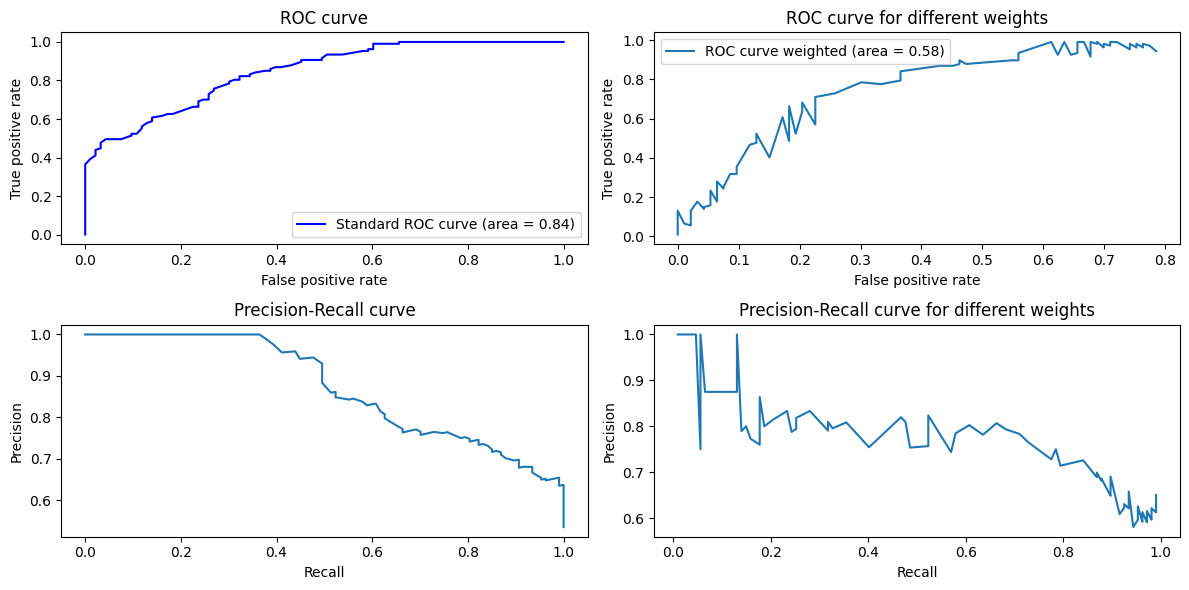

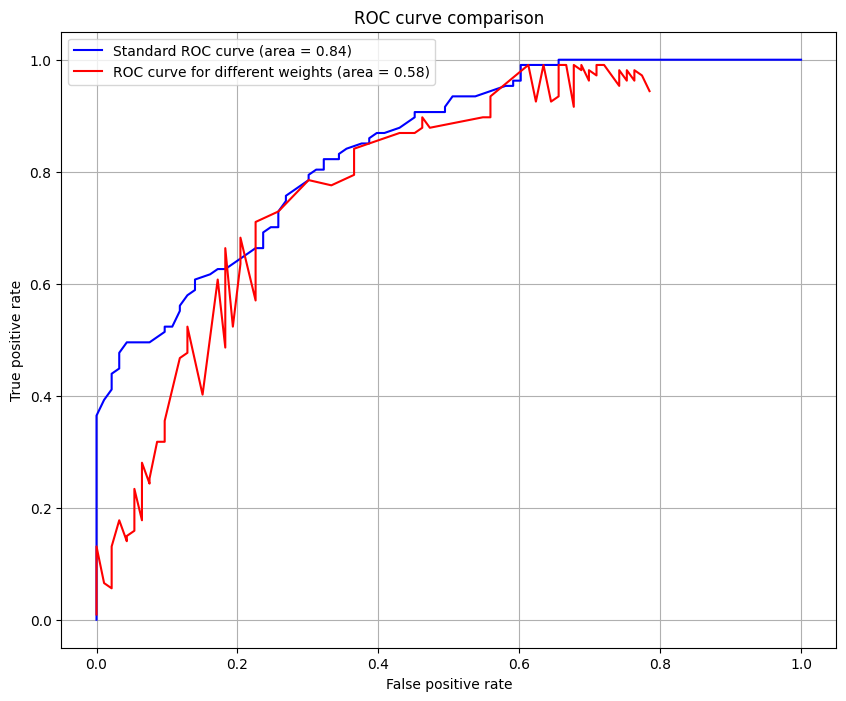

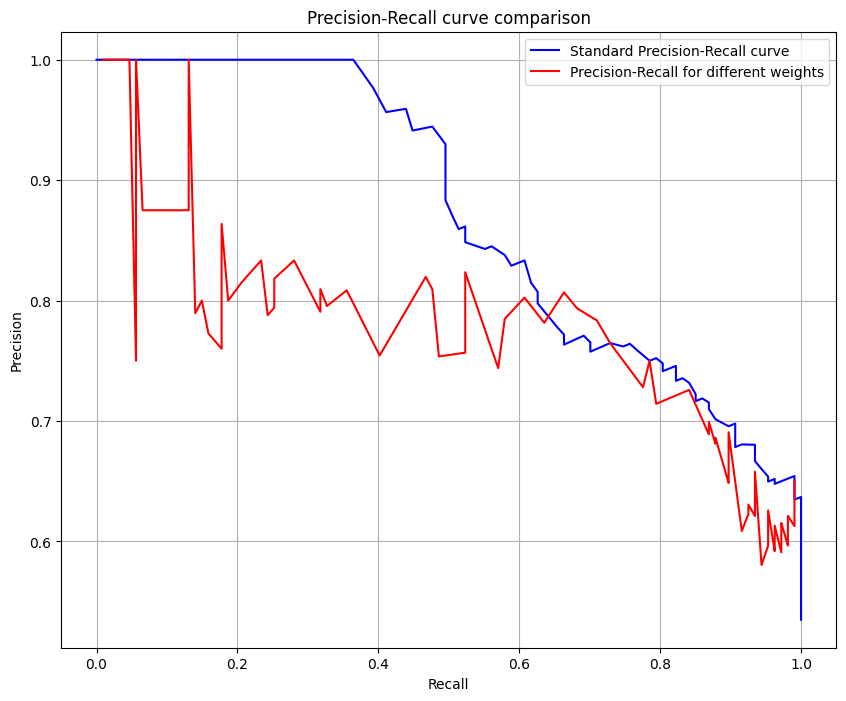

In [11]:
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.cluster import KMeans

# count the class 0 and class 1 samples in y_train
counter = Counter(y_train)
Class0_initial = counter[0]
Class1_initial = counter[1]

# Weight the X_train and y_train for cost-sensitive learning
class_ratio = Class0_initial / Class1_initial
#alpha_target = np.arange(class_ratio-0.99, class_ratio+0.99, 0.01)

# Define the number of points below and above the class_ratio
# You can adjust these to control the density of points
num_points_below = 50
num_points_above = 50
class_ratio_low = 0.001  # Minimum value for class_ratio
class_ratio_high = 1000.0  # Maximum value for class_ratio

# --- Configuration ---
STD_MIN_VALUE = 0.5
STD_MAX_VALUE = 2.0
EPSILON = 1e-9  # For checking non-zero std dev

log_class_ratio_low = np.log(class_ratio_low)
log_class_ratio_high = np.log(class_ratio_high)

# Define expected modes for each class (you'll need to set this based on your data)
# Example: {class_label: number_of_modes}
EXPECTED_MODES_PER_CLASS = {
    0: 2,  # Assuming class 0 has 2 modes
    1: 2   # Assuming class 1 has 2 modes
}

# Generate points below class_ratio with smaller increments
# Using geomspace for a geometric progression
if class_ratio > class_ratio_low:
    alpha_below = np.geomspace(class_ratio_low, class_ratio, num_points_below, endpoint=False)
else:
    alpha_below = np.array([]) # Handle cases where class_ratio is very small

# Generate points above class_ratio with larger, geometric increments
if class_ratio < class_ratio_high:
    alpha_above = np.geomspace(class_ratio, class_ratio_high, num_points_above)
else:
    # If class_ratio is already >= 1000, we might just want 1000 or an empty array
    alpha_above = np.array([class_ratio_high]) if class_ratio == class_ratio_high else (np.array([]) if class_ratio > class_ratio_high else np.geomspace(class_ratio, class_ratio_high, num_points_above))


# Combine the arrays and remove duplicates (especially class_ratio itself)
alpha_target = np.unique(np.concatenate((alpha_below, alpha_above)))

dict_weighted_clfs = {}
for w in alpha_target:
    
    # calculate the class weights
    if w >= class_ratio:
        Class0_final = int(Class1_initial * w)
        print(f"Class0_final {Class0_final}, w {w}")
        if Class0_final < Class0_initial:
            print(f"Class0_final {Class0_final} is less than Class0_initial {Class0_initial}")
        sampling_strategy_dict = {0: Class0_final}
    elif w < class_ratio:
        Class1_final = int(Class0_initial / w)
        print(f"Class1_final {Class1_final}, w {w}")
        if Class1_final < Class1_initial:
            print(f"Class1_final {Class1_final} is less than Class1_initial {Class1_initial}")
        sampling_strategy_dict = {1: Class1_final}

    smote = SMOTE(sampling_strategy=sampling_strategy_dict, random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

    X_modified_resampled = X_resampled.copy()
    start_idx_synthetic = len(y_train) 
    num_synthetic_generated = len(y_resampled) - len(y_train)
    synthetic_samples_original_features = X_resampled[start_idx_synthetic:]
    n_clusters_for_synthetic = 2
    MIN_SAMPLES_PER_SYNTHETIC_CLUSTER = 5
    MIN_SAMPLES_FOR_CLUSTERING_GLOBAL = 10

    # Scale the standard deviation of the synthetic samples
    log_w = np.log(w)
    proportion = (log_w - log_class_ratio_low) / (log_class_ratio_high - log_class_ratio_low)
    proportion = np.clip(proportion, 0.0, 1.0)  # Ensure it's within [0, 1]
    target_std_for_synthetic = STD_MIN_VALUE + proportion * (STD_MAX_VALUE - STD_MIN_VALUE)

    # Attempt localized scaling if enough samples and modes > 1
    attempt_localized_scaling = (n_clusters_for_synthetic > 1 and
                                    num_synthetic_generated >= n_clusters_for_synthetic * MIN_SAMPLES_PER_SYNTHETIC_CLUSTER and
                                    num_synthetic_generated >= MIN_SAMPLES_FOR_CLUSTERING_GLOBAL)

    if attempt_localized_scaling:
        print(f"  INFO: Applying localized scaling: Clustering {num_synthetic_generated} synthetic samples into {n_clusters_for_synthetic} groups.")
        try:
            kmeans = KMeans(n_clusters=n_clusters_for_synthetic, random_state=42, n_init='auto')
            cluster_labels_for_synthetic = kmeans.fit_predict(synthetic_samples_original_features)

            for i in range(n_clusters_for_synthetic):
                current_cluster_indices_in_block = np.where(cluster_labels_for_synthetic == i)[0]
                
                if len(current_cluster_indices_in_block) < MIN_SAMPLES_PER_SYNTHETIC_CLUSTER:
                    print(f"    WARNING: Synthetic cluster {i} has only {len(current_cluster_indices_in_block)} samples. Applying global scaling to this small cluster's points (within block).")
                    # Fallback for this specific small cluster: scale it globally (within its own points) Localized scaling is not possible
                    # Scale the small cluster's points globally
                    # This is a fallback to ensure we don't skip small clusters
                    if len(current_cluster_indices_in_block) > 0:
                        small_cluster_global_indices = start_idx_synthetic + current_cluster_indices_in_block
                        for feature_idx in range(X_modified_resampled.shape[1]):
                            feature_data_small_cluster = X_modified_resampled[small_cluster_global_indices, feature_idx]
                            mean_val = np.mean(feature_data_small_cluster)
                            std_val = np.std(feature_data_small_cluster)
                            if std_val > EPSILON:
                                centered = feature_data_small_cluster - mean_val
                                scaled = centered * (target_std_for_synthetic / std_val)
                                X_modified_resampled[small_cluster_global_indices, feature_idx] = scaled + mean_val
                    continue # Move to next K-Means cluster
                
                print(f"    INFO: Processing synthetic K-Means cluster {i} with {len(current_cluster_indices_in_block)} samples for localized std dev adjustment.")
                current_cluster_global_indices = start_idx_synthetic + current_cluster_indices_in_block

                for feature_idx in range(X_modified_resampled.shape[1]):
                    feature_data_current_cluster = X_modified_resampled[current_cluster_global_indices, feature_idx]
                    mean_feature_current_cluster = np.mean(feature_data_current_cluster)
                    std_feature_current_cluster = np.std(feature_data_current_cluster)

                    if std_feature_current_cluster > EPSILON:
                        centered_data = feature_data_current_cluster - mean_feature_current_cluster
                        scaled_data = centered_data * (target_std_for_synthetic / std_feature_current_cluster)
                        X_modified_resampled[current_cluster_global_indices, feature_idx] = scaled_data + mean_feature_current_cluster
                    else:
                        print(f"    WARNING: Feature {feature_idx} in synthetic cluster {i} has std dev ~0. Not scaling.")
            print("  INFO: Localized scaling applied.")
        except Exception as e:
            print(f"  ERROR: Error during K-Means clustering or localized scaling: {e}. Applying global scaling as fallback for all synthetic samples.")
            attempt_localized_scaling = False # Force global fallback
    
    if not attempt_localized_scaling: # Global scaling for all synthetic points
        if n_clusters_for_synthetic > 1 : # Only print if localized was intended but failed/skipped
                print(f"  INFO: Applying global scaling for all {num_synthetic_generated} synthetic samples (fallback or not enough samples/modes for localized).")
        synthetic_samples_to_modify = X_modified_resampled[start_idx_synthetic:]
        for feature_idx in range(synthetic_samples_to_modify.shape[1]):
            mean_feature_synthetic = np.mean(synthetic_samples_to_modify[:, feature_idx])
            std_feature_synthetic = np.std(synthetic_samples_to_modify[:, feature_idx])
            if std_feature_synthetic > EPSILON:
                centered_data = synthetic_samples_to_modify[:, feature_idx] - mean_feature_synthetic
                scaled_data = centered_data * (target_std_for_synthetic / std_feature_synthetic)
                X_modified_resampled[start_idx_synthetic:, feature_idx] = scaled_data + mean_feature_synthetic
            else:
                print(f"  WARNING: Feature {feature_idx} (global) of synthetic samples has std dev ~0. Not scaling.")
        print("  INFO: Global scaling applied to synthetic samples.")



    # Fit the Random Forest classifier with the resampled data
    clf_weighted = RandomForestClassifier(random_state=42)
    clf_weighted.fit(X_modified_resampled, y_resampled)

    res = get_fpr_tpr(clf_weighted, X_test, y_test)
    dict_weighted_clfs[w] = {
        "model": clf_weighted,
        "fpr": res["fpr"],
        "tpr": res["tpr"],
        "precision": res["precision"],
        "recall": res["recall"],
        "f1": res["f1"],
        "accuracy": res["accuracy"],
        "misclassification_rate": res["misclassification_rate"]
    }
    #print(f"Weight: {w:.2f}, FPR: {res['fpr']:.3f}, TPR: {res['tpr']:.3f}")

# Extract and sort FPR and TPR values from the weighted classifiers
fpr_weighted = [v["fpr"] for v in dict_weighted_clfs.values()]
tpr_weighted = [v["tpr"] for v in dict_weighted_clfs.values()]
roc_points = sorted(zip(fpr_weighted, tpr_weighted))
fpr_weighted_sorted = [p[0] for p in roc_points]
tpr_weighted_sorted = [p[1] for p in roc_points]

# Calculate AUC for weighted ROC curve
roc_auc_weighted = auc(fpr_weighted_sorted, tpr_weighted_sorted)

# Plot the FPR vs TPR for the different weights
fig,ax = plt.subplots(2, 2, figsize=(12, 6))
ax[0][0].plot(fpr_roc, tpr_roc, label=f'Standard ROC curve (area = {roc_auc:.2f})', color='blue')
ax[0][0].set_xlabel('False positive rate')
ax[0][0].set_ylabel('True positive rate')
ax[0][0].set_title('ROC curve')
ax[0][0].legend()
ax[0][1].plot(fpr_weighted_sorted, tpr_weighted_sorted, label=f'ROC curve weighted (area = {roc_auc_weighted:.2f})')
ax[0][1].set_xlabel('False positive rate')
ax[0][1].set_ylabel('True positive rate')
ax[0][1].set_title('ROC curve for different weights')
ax[0][1].legend()
ax[1][0].plot(recall_prc, precision_prc)
ax[1][0].set_xlabel('Recall')
ax[1][0].set_ylabel('Precision')
ax[1][0].set_title('Precision-Recall curve')

# Extract and sort precision-recall values
recall_weighted = [v["recall"] for v in dict_weighted_clfs.values()]
precision_weighted = [v["precision"] for v in dict_weighted_clfs.values()]
pr_points = sorted(zip(recall_weighted, precision_weighted))
recall_weighted_sorted = [p[0] for p in pr_points]
precision_weighted_sorted = [p[1] for p in pr_points]

ax[1][1].plot(recall_weighted_sorted, precision_weighted_sorted)
ax[1][1].set_xlabel('Recall')
ax[1][1].set_ylabel('Precision')
ax[1][1].set_title('Precision-Recall curve for different weights')
plt.tight_layout()
plt.show()

# Plot both ROC curves on the same plot figure
plt.figure(figsize=(10, 8))
plt.plot(fpr_roc, tpr_roc, label=f'Standard ROC curve (area = {roc_auc:.2f})', color='blue')
plt.plot(fpr_weighted_sorted, tpr_weighted_sorted, label=f'ROC curve for different weights (area = {roc_auc_weighted:.2f})', color='red')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()
plt.title('ROC curve comparison')
plt.grid(True)
plt.show()

# Plot both Precision-Recall curves on the same plot figure
plt.figure(figsize=(10, 8))
plt.plot(recall_prc, precision_prc, label='Standard Precision-Recall curve', color='blue')
plt.plot(recall_weighted_sorted, precision_weighted_sorted, label='Precision-Recall for different weights', color='red')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title('Precision-Recall curve comparison')
plt.grid(True)
plt.show()


## Update method for RoC-like curve generation (KDE-like approach)*
* Generate new sample as:
$$X^* \sim \textit{Unif}[0,len(Y_{train})]$$
$$X' = X^* + \sigma \epsilon$$
where $\sigma \leq 0.5$ the standard deviation in the original data and $\epsilon \sim \mathcal{N}[0,1]$
* Classify the synthetic sample as the oversampled class

INFO: Initial C0=407, C1=393, Ratio(0/1): 1.0356234096692112
INFO: Target ratios (w values): [ 0.1         0.10236512  0.10478619  0.10726451  0.10980145  0.11239839
  0.11505675  0.11777799  0.12056358  0.12341506  0.12633398  0.12932194
  0.13238056  0.13551153  0.13871654  0.14199736  0.14535578  0.14879362
  0.15231278  0.15591516  0.15960275  0.16337755  0.16724164  0.17119711
  0.17524613  0.17939092  0.18363374  0.18797691  0.1924228   0.19697383
  0.20163251  0.20640137  0.21128302  0.21628013  0.22139542  0.2266317
  0.23199182  0.23747871  0.24309538  0.24884489  0.25473038  0.26075507
  0.26692225  0.2732353   0.27969765  0.28631285  0.2930845   0.30001632
  0.30711207  0.31437566  0.32181103  0.32942226  0.33721351  0.34518903
  0.35335318  0.36171042  0.37026532  0.37902256  0.38798691  0.39716329
  0.40655669  0.41617226  0.42601526  0.43609105  0.44640514  0.45696318
  0.46777093  0.47883429  0.49015932  0.5017522   0.51361926  0.52576699
  0.53820204  0.55093119  0.5639

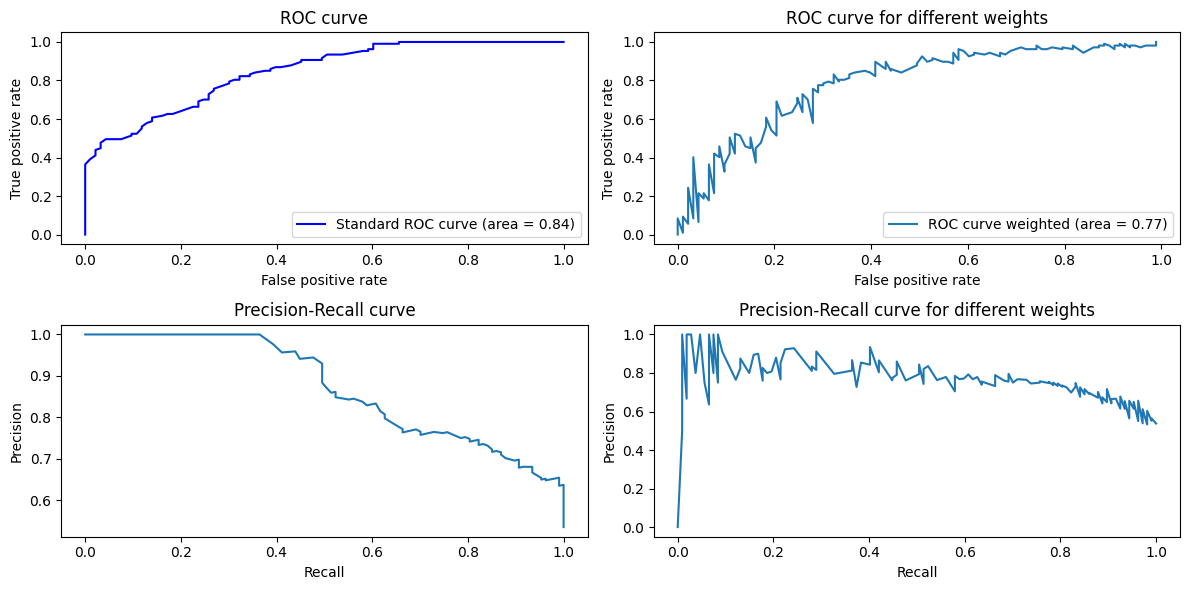

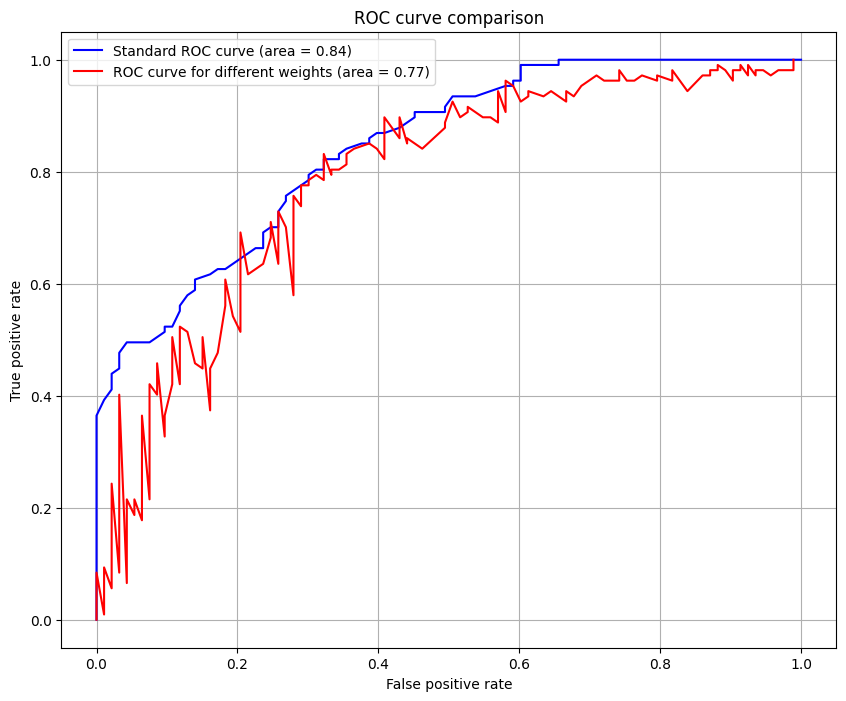

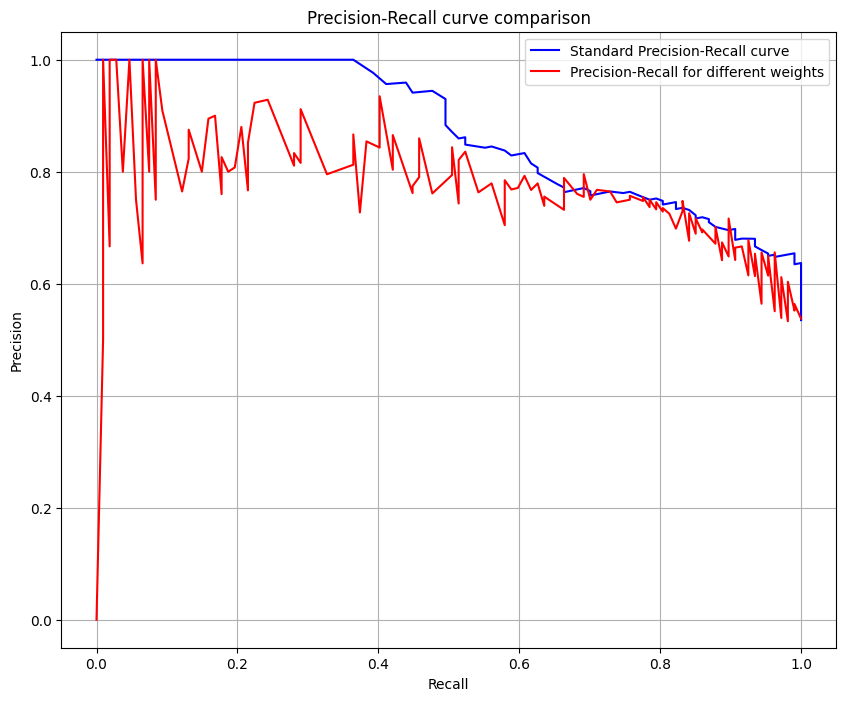

In [8]:
import numpy as np
from collections import Counter
# from imblearn.over_sampling import SMOTE # SMOTE is no longer used
# from sklearn.cluster import KMeans # K-Means is no longer used

# --- Configuration ---
EPSILON = 1e-9
# EXPECTED_MODES_PER_CLASS, etc. removed
# FIXED_TARGET_STD_SYNTHETIC removed

# --- Parameter for KDE-like generator ---
SIGMA_KDE_PERTURBATION = 0.1 # Adjust as needed



# --- Initial Data Analysis ---
counter = Counter(y_train)
Class0_initial = counter.get(0, 0)
Class1_initial = counter.get(1, 0)

class_ratio_low = 0.1   
class_ratio_high = 10.0 
num_points_below = 100 
num_points_above = 100 

if Class1_initial == 0 and Class0_initial == 0:
    print("ERROR: Both classes have zero samples initially. Cannot proceed.")
    alpha_target_actual_values = [] 
    current_class_ratio = 1.0
elif Class1_initial == 0:
    current_class_ratio = np.inf 
else:
    current_class_ratio = Class0_initial / Class1_initial

# ... (alpha_target_actual_values generation - same robust version) ...
alpha_target_list = []
if Class0_initial > 0 or Class1_initial > 0: 
    if current_class_ratio > 0 and not np.isinf(current_class_ratio): 
        alpha_target_list.append(current_class_ratio)
    _safe_class_ratio_low = max(class_ratio_low, EPSILON)
    if current_class_ratio > _safe_class_ratio_low and not np.isinf(current_class_ratio): 
        try:
            alpha_b = np.geomspace(_safe_class_ratio_low, current_class_ratio, num_points_below, endpoint=False)
            alpha_target_list.extend(alpha_b)
        except ValueError: pass
    if current_class_ratio < class_ratio_high and current_class_ratio >= 0 and not np.isinf(current_class_ratio): 
        try:
            _start_geom_above = max(current_class_ratio, _safe_class_ratio_low) 
            if class_ratio_high > _start_geom_above:
                 alpha_a = np.geomspace(_start_geom_above, class_ratio_high, num_points_above, endpoint=True)
                 if not np.isclose(_start_geom_above, current_class_ratio) and current_class_ratio >=_safe_class_ratio_low and current_class_ratio <= class_ratio_high :
                     alpha_target_list.append(current_class_ratio)
                 alpha_target_list.extend(alpha_a)
            elif np.isclose(class_ratio_high, _start_geom_above):
                 alpha_target_list.append(class_ratio_high)
        except ValueError: pass
    if not alpha_target_list and (Class0_initial > 0 or Class1_initial > 0): 
        if not np.isinf(current_class_ratio) and current_class_ratio > 0:
            alpha_target_list.append(current_class_ratio)
        else: 
            alpha_target_list.extend(np.geomspace(_safe_class_ratio_low, class_ratio_high, num_points_below + num_points_above))
    alpha_target_actual_values = np.unique(alpha_target_list)
    alpha_target_actual_values = np.sort(alpha_target_actual_values[alpha_target_actual_values >= 0]) 
    alpha_target_actual_values = alpha_target_actual_values[alpha_target_actual_values >= _safe_class_ratio_low] 
    alpha_target_actual_values = alpha_target_actual_values[alpha_target_actual_values <= class_ratio_high]
    if not alpha_target_actual_values.size and (Class0_initial > 0 or Class1_initial > 0) : 
        if not np.isinf(current_class_ratio) and current_class_ratio > _safe_class_ratio_low and current_class_ratio < class_ratio_high:
            alpha_target_actual_values = np.array([current_class_ratio])
        else: 
            alpha_target_actual_values = np.array([(_safe_class_ratio_low + class_ratio_high)/2.0])


print(f"INFO: Initial C0={Class0_initial}, C1={Class1_initial}, Ratio(0/1): {current_class_ratio if Class1_initial > 0 else 'N/A'}")
print(f"INFO: Target ratios (w values): {alpha_target_actual_values}")
print(f"INFO: KDE-like perturbation sigma: {SIGMA_KDE_PERTURBATION}")
print(f"INFO: Standard deviation of synthetic samples will NOT be modified after generation.")

dict_weighted_clfs = {}

# --- Main Loop ---
for w_idx, w in enumerate(alpha_target_actual_values):
    print(f"\n--- Processing target ratio w ({w_idx+1}/{len(alpha_target_actual_values)}): {w:.4f} ---")

    # --- Determine Oversampling Strategy ---
    sampling_strategy_determined = False
    oversampled_class_label_by_strategy = -1
    initial_count_of_oversampled_class = -1
    final_count_of_oversampled_class = -1
    num_synthetic_to_generate = 0

    if Class1_initial == 0:
        if Class0_initial > 0 and w > EPSILON: 
            _Class1_final = int(round(Class0_initial / w))
            if _Class1_final > Class1_initial:
                oversampled_class_label_by_strategy = 1
                initial_count_of_oversampled_class = Class1_initial
                final_count_of_oversampled_class = _Class1_final
                sampling_strategy_determined = True
    elif w >= current_class_ratio: 
        _Class0_final = int(round(Class1_initial * w))
        if _Class0_final > Class0_initial:
            oversampled_class_label_by_strategy = 0
            initial_count_of_oversampled_class = Class0_initial
            final_count_of_oversampled_class = _Class0_final
            sampling_strategy_determined = True
    elif w < current_class_ratio: 
        if w > EPSILON: 
            _Class1_final = int(round(Class0_initial / w))
            if _Class1_final > Class1_initial:
                oversampled_class_label_by_strategy = 1
                initial_count_of_oversampled_class = Class1_initial
                final_count_of_oversampled_class = _Class1_final
                sampling_strategy_determined = True
    

    
    num_synthetic_to_generate = final_count_of_oversampled_class - initial_count_of_oversampled_class
    print(f"  INFO: Strategy: Oversample class {oversampled_class_label_by_strategy} from {initial_count_of_oversampled_class} to {final_count_of_oversampled_class} (generating {num_synthetic_to_generate} samples).")



    # --- KDE-like Synthetic Sample Generation ---
    print(f"  INFO: Using KDE-like generator. Perturbation sigma: {SIGMA_KDE_PERTURBATION}")
    X_new_synthetic = []
    y_new_synthetic = []

    if len(X_train) == 0:
        print("  WARNING: X_train is empty, cannot generate synthetic samples with KDE-like method.")
        X_resampled = X_train.copy()
        y_resampled = y_train.copy()
    else:
        for _ in range(num_synthetic_to_generate):
            idx_star = np.random.randint(0, len(X_train))
            X_star = X_train[idx_star]
            epsilon_noise = np.random.randn(*X_star.shape) 
            X_prime = X_star + SIGMA_KDE_PERTURBATION * epsilon_noise
            X_new_synthetic.append(X_prime)
            y_new_synthetic.append(oversampled_class_label_by_strategy)

        if not X_new_synthetic:
            print("  INFO: No synthetic samples were actually generated by KDE-like method.")
            X_resampled = X_train.copy()
            y_resampled = y_train.copy()
        else:
            X_new_synthetic_arr = np.array(X_new_synthetic)
            y_new_synthetic_arr = np.array(y_new_synthetic)
            X_resampled = np.vstack((X_train, X_new_synthetic_arr))
            y_resampled = np.concatenate((y_train, y_new_synthetic_arr))
            resampled_counts = Counter(y_resampled)
            print(f"  INFO: KDE-like generation complete. New C0={resampled_counts.get(0,0)}, C1={resampled_counts.get(1,0)}")

    # Fit the Random Forest classifier with the resampled data
    clf_weighted = RandomForestClassifier(random_state=42)
    clf_weighted.fit(X_resampled, y_resampled)

    res = get_fpr_tpr(clf_weighted, X_test, y_test)
    dict_weighted_clfs[w] = {
        "model": clf_weighted,
        "fpr": res["fpr"],
        "tpr": res["tpr"],
        "precision": res["precision"],
        "recall": res["recall"],
        "f1": res["f1"],
        "accuracy": res["accuracy"],
        "misclassification_rate": res["misclassification_rate"]
    }
    #print(f"Weight: {w:.2f}, FPR: {res['fpr']:.3f}, TPR: {res['tpr']:.3f}")

# Extract and sort FPR and TPR values from the weighted classifiers
fpr_weighted = [v["fpr"] for v in dict_weighted_clfs.values()]
tpr_weighted = [v["tpr"] for v in dict_weighted_clfs.values()]
roc_points = sorted(zip(fpr_weighted, tpr_weighted))
fpr_weighted_sorted = [p[0] for p in roc_points]
tpr_weighted_sorted = [p[1] for p in roc_points]

# Calculate AUC for weighted ROC curve
roc_auc_weighted = auc(fpr_weighted_sorted, tpr_weighted_sorted)

# Plot the FPR vs TPR for the different weights
fig,ax = plt.subplots(2, 2, figsize=(12, 6))
ax[0][0].plot(fpr_roc, tpr_roc, label=f'Standard ROC curve (area = {roc_auc:.2f})', color='blue')
ax[0][0].set_xlabel('False positive rate')
ax[0][0].set_ylabel('True positive rate')
ax[0][0].set_title('ROC curve')
ax[0][0].legend()
ax[0][1].plot(fpr_weighted_sorted, tpr_weighted_sorted, label=f'ROC curve weighted (area = {roc_auc_weighted:.2f})')
ax[0][1].set_xlabel('False positive rate')
ax[0][1].set_ylabel('True positive rate')
ax[0][1].set_title('ROC curve for different weights')
ax[0][1].legend()
ax[1][0].plot(recall_prc, precision_prc)
ax[1][0].set_xlabel('Recall')
ax[1][0].set_ylabel('Precision')
ax[1][0].set_title('Precision-Recall curve')

# Extract and sort precision-recall values
recall_weighted = [v["recall"] for v in dict_weighted_clfs.values()]
precision_weighted = [v["precision"] for v in dict_weighted_clfs.values()]
pr_points = sorted(zip(recall_weighted, precision_weighted))
recall_weighted_sorted = [p[0] for p in pr_points]
precision_weighted_sorted = [p[1] for p in pr_points]

ax[1][1].plot(recall_weighted_sorted, precision_weighted_sorted)
ax[1][1].set_xlabel('Recall')
ax[1][1].set_ylabel('Precision')
ax[1][1].set_title('Precision-Recall curve for different weights')
plt.tight_layout()
plt.show()

# Plot both ROC curves on the same plot figure
plt.figure(figsize=(10, 8))
plt.plot(fpr_roc, tpr_roc, label=f'Standard ROC curve (area = {roc_auc:.2f})', color='blue')
plt.plot(fpr_weighted_sorted, tpr_weighted_sorted, label=f'ROC curve for different weights (area = {roc_auc_weighted:.2f})', color='red')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()
plt.title('ROC curve comparison')
plt.grid(True)
plt.show()

# Plot both Precision-Recall curves on the same plot figure
plt.figure(figsize=(10, 8))
plt.plot(recall_prc, precision_prc, label='Standard Precision-Recall curve', color='blue')
plt.plot(recall_weighted_sorted, precision_weighted_sorted, label='Precision-Recall for different weights', color='red')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title('Precision-Recall curve comparison')
plt.grid(True)
plt.show()


#print(f"\n--- Finished processing. {len(dict_weighted_clfs)} scenarios stored in dict_weighted_clfs. ---")

## KDE-like curve with synthetic samples from only the minority class
* Make Class0_initial = 0 so that current_class_ratio = 0 i.e oversample class 0
* Make Class1_initial = 0 so that current_class_ratio = inf i.e oversample class 1

INFO: Initial C0=0, C1=393, Ratio(0/1): 0.0
INFO: Target ratios (w values): [ 0.1         0.10476158  0.10974988  0.1149757   0.12045035  0.12618569
  0.13219411  0.13848864  0.14508288  0.15199111  0.15922828  0.16681005
  0.17475284  0.18307383  0.19179103  0.2009233   0.21049041  0.22051307
  0.23101297  0.24201283  0.25353645  0.26560878  0.27825594  0.29150531
  0.30538555  0.31992671  0.33516027  0.35111917  0.36783798  0.38535286
  0.40370173  0.42292429  0.44306215  0.46415888  0.48626016  0.5094138
  0.53366992  0.55908102  0.58570208  0.61359073  0.64280731  0.67341507
  0.70548023  0.7390722   0.77426368  0.81113083  0.84975344  0.89021509
  0.93260335  0.97700996  1.02353102  1.07226722  1.12332403  1.17681195
  1.23284674  1.29154967  1.35304777  1.41747416  1.48496826  1.55567614
  1.62975083  1.70735265  1.78864953  1.87381742  1.96304065  2.05651231
  2.15443469  2.25701972  2.36448941  2.47707636  2.59502421  2.71858824
  2.84803587  2.98364724  3.12571585  3.27454916 

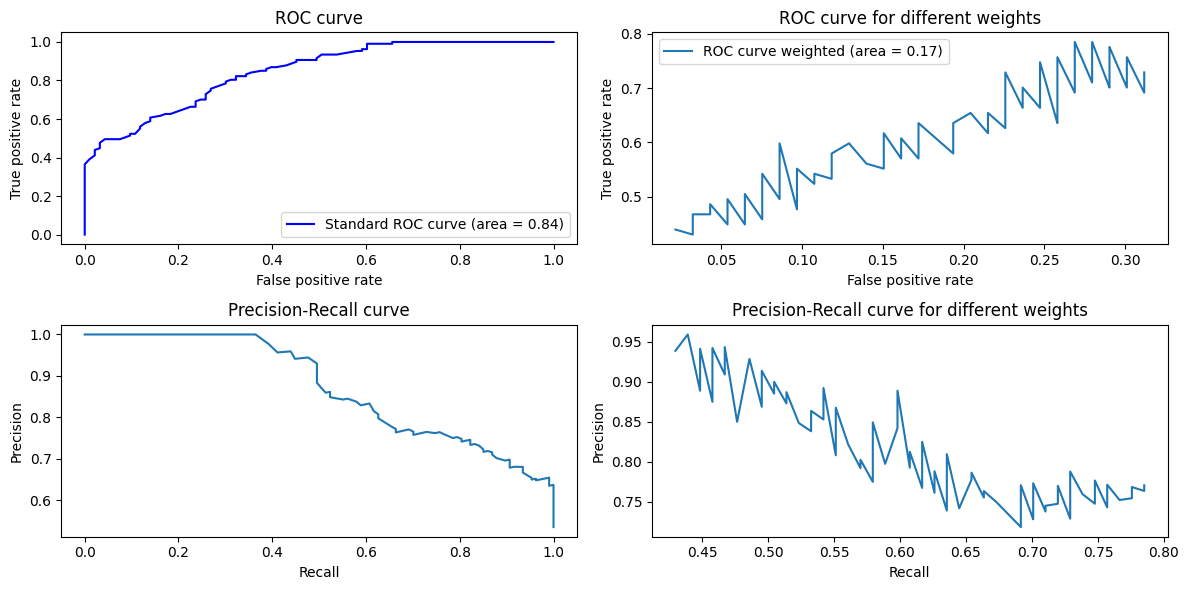

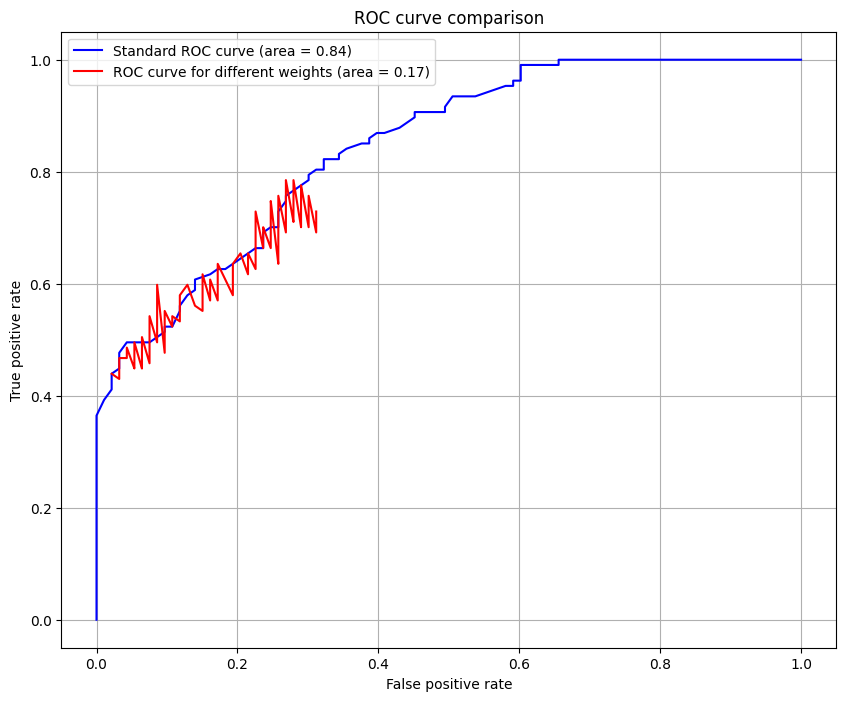

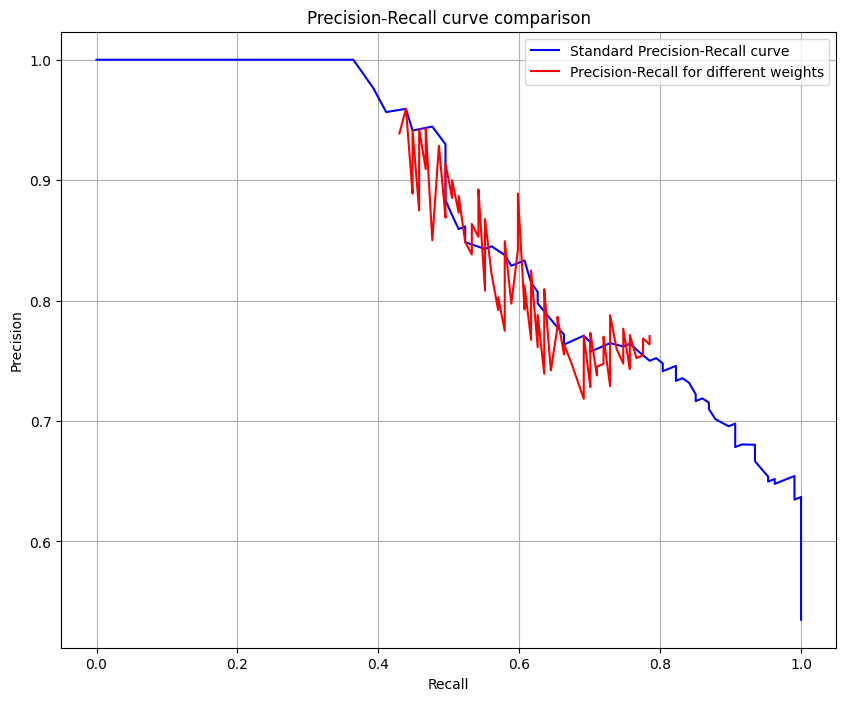

In [9]:
import numpy as np
from collections import Counter
# from imblearn.over_sampling import SMOTE # SMOTE is no longer used
# from sklearn.cluster import KMeans # K-Means is no longer used

# --- Configuration ---
EPSILON = 1e-9
# EXPECTED_MODES_PER_CLASS, etc. removed
# FIXED_TARGET_STD_SYNTHETIC removed

# --- Parameter for KDE-like generator ---
SIGMA_KDE_PERTURBATION = 0.1 # Adjust as needed



# --- Initial Data Analysis ---
counter = Counter(y_train)
#Class0_initial = counter.get(0, 0)
Class0_initial = 0
Class1_initial = counter.get(1, 0)

class_ratio_low = 0.1   
class_ratio_high = 10.0 
num_points_below = 100 
num_points_above = 100 

if Class1_initial == 0 and Class0_initial == 0:
    print("ERROR: Both classes have zero samples initially. Cannot proceed.")
    alpha_target_actual_values = [] 
    current_class_ratio = 1.0
elif Class1_initial == 0:
    current_class_ratio = np.inf 
else:
    current_class_ratio = Class0_initial / Class1_initial

# ... (alpha_target_actual_values generation - same robust version) ...
alpha_target_list = []
if Class0_initial > 0 or Class1_initial > 0: 
    if current_class_ratio > 0 and not np.isinf(current_class_ratio): 
        alpha_target_list.append(current_class_ratio)
    _safe_class_ratio_low = max(class_ratio_low, EPSILON)
    if current_class_ratio > _safe_class_ratio_low and not np.isinf(current_class_ratio): 
        try:
            alpha_b = np.geomspace(_safe_class_ratio_low, current_class_ratio, num_points_below, endpoint=False)
            alpha_target_list.extend(alpha_b)
        except ValueError: pass
    if current_class_ratio < class_ratio_high and current_class_ratio >= 0 and not np.isinf(current_class_ratio): 
        try:
            _start_geom_above = max(current_class_ratio, _safe_class_ratio_low) 
            if class_ratio_high > _start_geom_above:
                 alpha_a = np.geomspace(_start_geom_above, class_ratio_high, num_points_above, endpoint=True)
                 if not np.isclose(_start_geom_above, current_class_ratio) and current_class_ratio >=_safe_class_ratio_low and current_class_ratio <= class_ratio_high :
                     alpha_target_list.append(current_class_ratio)
                 alpha_target_list.extend(alpha_a)
            elif np.isclose(class_ratio_high, _start_geom_above):
                 alpha_target_list.append(class_ratio_high)
        except ValueError: pass
    if not alpha_target_list and (Class0_initial > 0 or Class1_initial > 0): 
        if not np.isinf(current_class_ratio) and current_class_ratio > 0:
            alpha_target_list.append(current_class_ratio)
        else: 
            alpha_target_list.extend(np.geomspace(_safe_class_ratio_low, class_ratio_high, num_points_below + num_points_above))
    alpha_target_actual_values = np.unique(alpha_target_list)
    alpha_target_actual_values = np.sort(alpha_target_actual_values[alpha_target_actual_values >= 0]) 
    alpha_target_actual_values = alpha_target_actual_values[alpha_target_actual_values >= _safe_class_ratio_low] 
    alpha_target_actual_values = alpha_target_actual_values[alpha_target_actual_values <= class_ratio_high]
    if not alpha_target_actual_values.size and (Class0_initial > 0 or Class1_initial > 0) : 
        if not np.isinf(current_class_ratio) and current_class_ratio > _safe_class_ratio_low and current_class_ratio < class_ratio_high:
            alpha_target_actual_values = np.array([current_class_ratio])
        else: 
            alpha_target_actual_values = np.array([(_safe_class_ratio_low + class_ratio_high)/2.0])


print(f"INFO: Initial C0={Class0_initial}, C1={Class1_initial}, Ratio(0/1): {current_class_ratio if Class1_initial > 0 else 'N/A'}")
print(f"INFO: Target ratios (w values): {alpha_target_actual_values}")
print(f"INFO: KDE-like perturbation sigma: {SIGMA_KDE_PERTURBATION}")
print(f"INFO: Standard deviation of synthetic samples will NOT be modified after generation.")

dict_weighted_clfs = {}

# --- Main Loop ---
for w_idx, w in enumerate(alpha_target_actual_values):
    print(f"\n--- Processing target ratio w ({w_idx+1}/{len(alpha_target_actual_values)}): {w:.4f} ---")

    # --- Determine Oversampling Strategy ---
    sampling_strategy_determined = False
    oversampled_class_label_by_strategy = -1
    initial_count_of_oversampled_class = -1
    final_count_of_oversampled_class = -1
    num_synthetic_to_generate = 0

    if Class1_initial == 0:
        if Class0_initial > 0 and w > EPSILON: 
            _Class1_final = int(round(Class0_initial / w))
            if _Class1_final > Class1_initial:
                oversampled_class_label_by_strategy = 1
                initial_count_of_oversampled_class = Class1_initial
                final_count_of_oversampled_class = _Class1_final
                sampling_strategy_determined = True
    elif w >= current_class_ratio: 
        _Class0_final = int(round(Class1_initial * w))
        if _Class0_final > Class0_initial:
            oversampled_class_label_by_strategy = 0
            initial_count_of_oversampled_class = Class0_initial
            final_count_of_oversampled_class = _Class0_final
            sampling_strategy_determined = True
    elif w < current_class_ratio: 
        if w > EPSILON: 
            _Class1_final = int(round(Class0_initial / w))
            if _Class1_final > Class1_initial:
                oversampled_class_label_by_strategy = 1
                initial_count_of_oversampled_class = Class1_initial
                final_count_of_oversampled_class = _Class1_final
                sampling_strategy_determined = True
    

    
    num_synthetic_to_generate = final_count_of_oversampled_class - initial_count_of_oversampled_class
    print(f"  INFO: Strategy: Oversample class {oversampled_class_label_by_strategy} from {initial_count_of_oversampled_class} to {final_count_of_oversampled_class} (generating {num_synthetic_to_generate} samples).")



    # --- KDE-like Synthetic Sample Generation ---
    print(f"  INFO: Using KDE-like generator. Perturbation sigma: {SIGMA_KDE_PERTURBATION}")
    X_new_synthetic = []
    y_new_synthetic = []

    indices_class_0 = np.where(y_train == 0)[0]

    if len(X_train) == 0:
        print("  WARNING: X_train is empty, cannot generate synthetic samples with KDE-like method.")
        X_resampled = X_train.copy()
        y_resampled = y_train.copy()
    else:
        for _ in range(num_synthetic_to_generate):
            #idx_star = np.random.randint(0, len(X_train))
            idx_star = np.random.choice(indices_class_0)  # Ensure we sample from class 0
            X_star = X_train[idx_star]
            epsilon_noise = np.random.randn(*X_star.shape) 
            X_prime = X_star + SIGMA_KDE_PERTURBATION * epsilon_noise
            X_new_synthetic.append(X_prime)
            y_new_synthetic.append(oversampled_class_label_by_strategy)

        if not X_new_synthetic:
            print("  INFO: No synthetic samples were actually generated by KDE-like method.")
            X_resampled = X_train.copy()
            y_resampled = y_train.copy()
        else:
            X_new_synthetic_arr = np.array(X_new_synthetic)
            y_new_synthetic_arr = np.array(y_new_synthetic)
            X_resampled = np.vstack((X_train, X_new_synthetic_arr))
            y_resampled = np.concatenate((y_train, y_new_synthetic_arr))
            resampled_counts = Counter(y_resampled)
            print(f"  INFO: KDE-like generation complete. New C0={resampled_counts.get(0,0)}, C1={resampled_counts.get(1,0)}")

    # Fit the Random Forest classifier with the resampled data
    clf_weighted = RandomForestClassifier(random_state=42)
    clf_weighted.fit(X_resampled, y_resampled)

    res = get_fpr_tpr(clf_weighted, X_test, y_test)
    dict_weighted_clfs[w] = {
        "model": clf_weighted,
        "fpr": res["fpr"],
        "tpr": res["tpr"],
        "precision": res["precision"],
        "recall": res["recall"],
        "f1": res["f1"],
        "accuracy": res["accuracy"],
        "misclassification_rate": res["misclassification_rate"]
    }
    #print(f"Weight: {w:.2f}, FPR: {res['fpr']:.3f}, TPR: {res['tpr']:.3f}")

# Extract and sort FPR and TPR values from the weighted classifiers
fpr_weighted = [v["fpr"] for v in dict_weighted_clfs.values()]
tpr_weighted = [v["tpr"] for v in dict_weighted_clfs.values()]
roc_points = sorted(zip(fpr_weighted, tpr_weighted))
fpr_weighted_sorted = [p[0] for p in roc_points]
tpr_weighted_sorted = [p[1] for p in roc_points]

# Calculate AUC for weighted ROC curve
roc_auc_weighted = auc(fpr_weighted_sorted, tpr_weighted_sorted)

# Plot the FPR vs TPR for the different weights
fig,ax = plt.subplots(2, 2, figsize=(12, 6))
ax[0][0].plot(fpr_roc, tpr_roc, label=f'Standard ROC curve (area = {roc_auc:.2f})', color='blue')
ax[0][0].set_xlabel('False positive rate')
ax[0][0].set_ylabel('True positive rate')
ax[0][0].set_title('ROC curve')
ax[0][0].legend()
ax[0][1].plot(fpr_weighted_sorted, tpr_weighted_sorted, label=f'ROC curve weighted (area = {roc_auc_weighted:.2f})')
ax[0][1].set_xlabel('False positive rate')
ax[0][1].set_ylabel('True positive rate')
ax[0][1].set_title('ROC curve for different weights')
ax[0][1].legend()
ax[1][0].plot(recall_prc, precision_prc)
ax[1][0].set_xlabel('Recall')
ax[1][0].set_ylabel('Precision')
ax[1][0].set_title('Precision-Recall curve')

# Extract and sort precision-recall values
recall_weighted = [v["recall"] for v in dict_weighted_clfs.values()]
precision_weighted = [v["precision"] for v in dict_weighted_clfs.values()]
pr_points = sorted(zip(recall_weighted, precision_weighted))
recall_weighted_sorted = [p[0] for p in pr_points]
precision_weighted_sorted = [p[1] for p in pr_points]

ax[1][1].plot(recall_weighted_sorted, precision_weighted_sorted)
ax[1][1].set_xlabel('Recall')
ax[1][1].set_ylabel('Precision')
ax[1][1].set_title('Precision-Recall curve for different weights')
plt.tight_layout()
plt.show()

# Plot both ROC curves on the same plot figure
plt.figure(figsize=(10, 8))
plt.plot(fpr_roc, tpr_roc, label=f'Standard ROC curve (area = {roc_auc:.2f})', color='blue')
plt.plot(fpr_weighted_sorted, tpr_weighted_sorted, label=f'ROC curve for different weights (area = {roc_auc_weighted:.2f})', color='red')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()
plt.title('ROC curve comparison')
plt.grid(True)
plt.show()

# Plot both Precision-Recall curves on the same plot figure
plt.figure(figsize=(10, 8))
plt.plot(recall_prc, precision_prc, label='Standard Precision-Recall curve', color='blue')
plt.plot(recall_weighted_sorted, precision_weighted_sorted, label='Precision-Recall for different weights', color='red')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title('Precision-Recall curve comparison')
plt.grid(True)
plt.show()


#print(f"\n--- Finished processing. {len(dict_weighted_clfs)} scenarios stored in dict_weighted_clfs. ---")

INFO: Initial C0=407, C1=0, Ratio(0/1): N/A
INFO: Target ratios (w values): [ 0.1         0.10234114  0.10473709  0.10718913  0.10969858  0.11226678
  0.1148951   0.11758496  0.12033778  0.12315506  0.12603829  0.12898903
  0.13200884  0.13509935  0.13826222  0.14149913  0.14481182  0.14820207
  0.15167169  0.15522254  0.15885651  0.16257557  0.16638169  0.17027692
  0.17426334  0.17834309  0.18251835  0.18679136  0.19116441  0.19563983
  0.20022004  0.20490747  0.20970464  0.21461412  0.21963854  0.22478058
  0.23004301  0.23542864  0.24094036  0.24658111  0.25235392  0.25826188
  0.26430815  0.27049597  0.27682866  0.28330961  0.28994229  0.29673024
  0.30367711  0.31078662  0.31806257  0.32550886  0.33312948  0.34092851
  0.34891012  0.3570786   0.36543831  0.37399373  0.38274945  0.39171015
  0.40088063  0.41026581  0.41987071  0.42970047  0.43976036  0.45005577
  0.4605922   0.47137531  0.48241087  0.49370479  0.50526311  0.51709202
  0.52919787  0.54158714  0.55426645  0.56724261

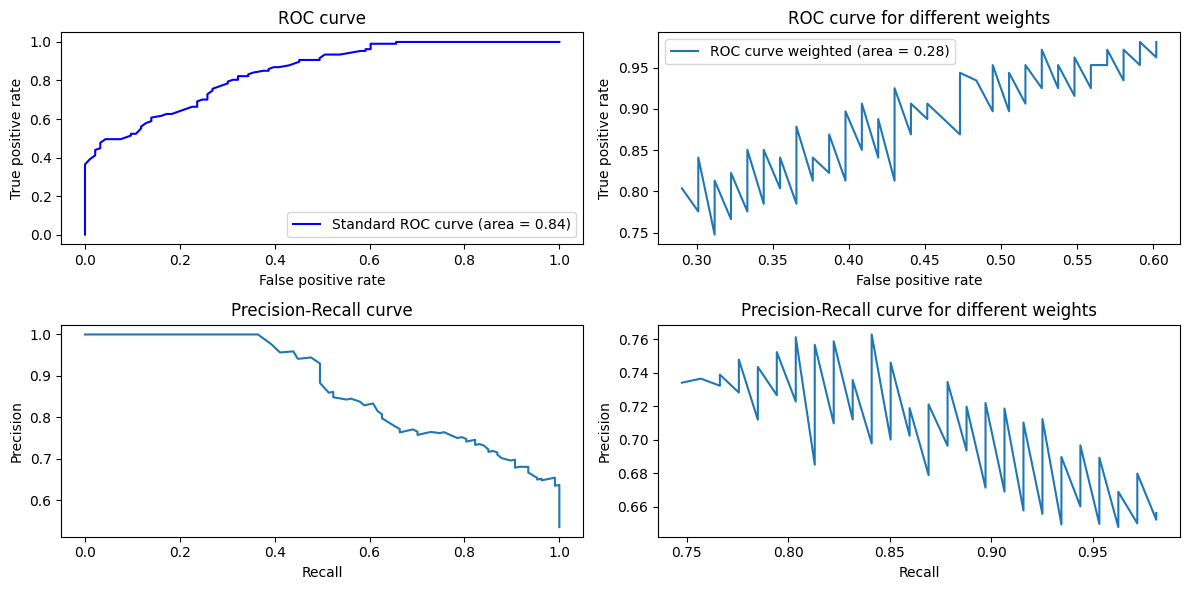

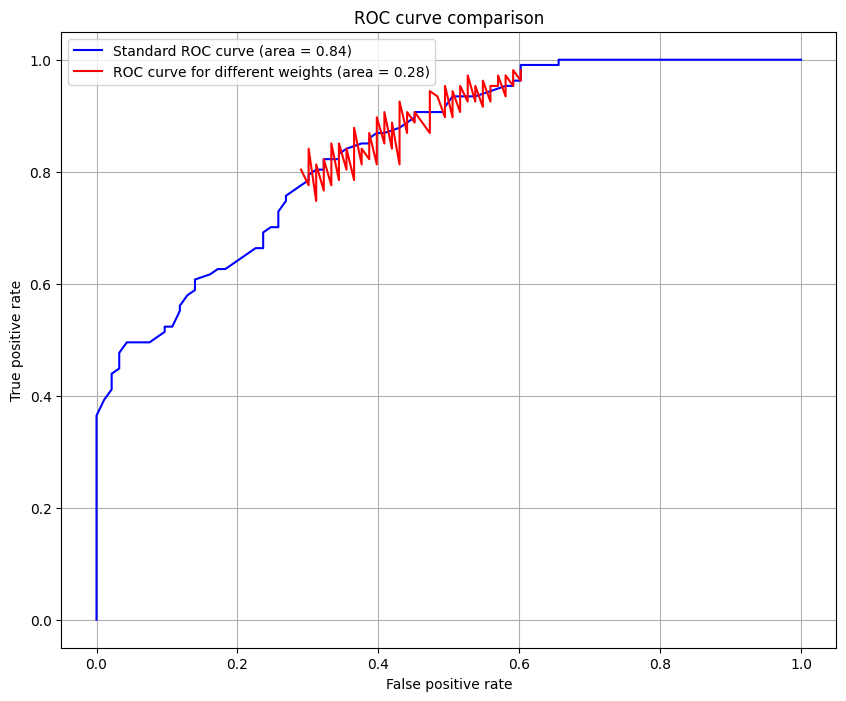

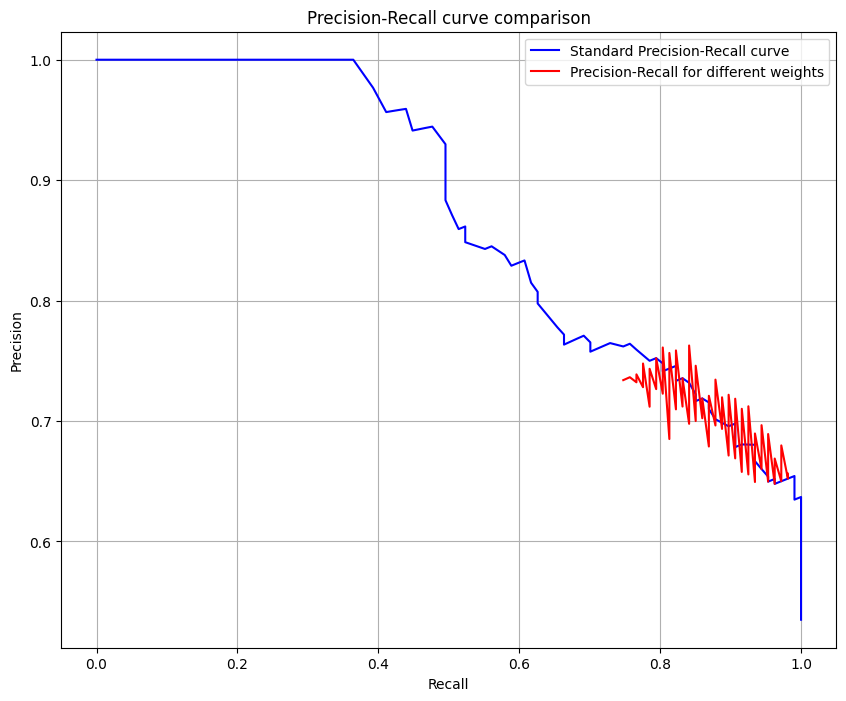

In [10]:
import numpy as np
from collections import Counter
# from imblearn.over_sampling import SMOTE # SMOTE is no longer used
# from sklearn.cluster import KMeans # K-Means is no longer used

# --- Configuration ---
EPSILON = 1e-9
# EXPECTED_MODES_PER_CLASS, etc. removed
# FIXED_TARGET_STD_SYNTHETIC removed

# --- Parameter for KDE-like generator ---
SIGMA_KDE_PERTURBATION = 0.1 # Adjust as needed



# --- Initial Data Analysis ---
counter = Counter(y_train)
Class0_initial = counter.get(0, 0)
#Class1_initial = counter.get(1, 0)
Class1_initial = 0

class_ratio_low = 0.1   
class_ratio_high = 10.0 
num_points_below = 100 
num_points_above = 100 

if Class1_initial == 0 and Class0_initial == 0:
    print("ERROR: Both classes have zero samples initially. Cannot proceed.")
    alpha_target_actual_values = [] 
    current_class_ratio = 1.0
elif Class1_initial == 0:
    current_class_ratio = np.inf 
else:
    current_class_ratio = Class0_initial / Class1_initial

# ... (alpha_target_actual_values generation - same robust version) ...
alpha_target_list = []
if Class0_initial > 0 or Class1_initial > 0: 
    if current_class_ratio > 0 and not np.isinf(current_class_ratio): 
        alpha_target_list.append(current_class_ratio)
    _safe_class_ratio_low = max(class_ratio_low, EPSILON)
    if current_class_ratio > _safe_class_ratio_low and not np.isinf(current_class_ratio): 
        try:
            alpha_b = np.geomspace(_safe_class_ratio_low, current_class_ratio, num_points_below, endpoint=False)
            alpha_target_list.extend(alpha_b)
        except ValueError: pass
    if current_class_ratio < class_ratio_high and current_class_ratio >= 0 and not np.isinf(current_class_ratio): 
        try:
            _start_geom_above = max(current_class_ratio, _safe_class_ratio_low) 
            if class_ratio_high > _start_geom_above:
                 alpha_a = np.geomspace(_start_geom_above, class_ratio_high, num_points_above, endpoint=True)
                 if not np.isclose(_start_geom_above, current_class_ratio) and current_class_ratio >=_safe_class_ratio_low and current_class_ratio <= class_ratio_high :
                     alpha_target_list.append(current_class_ratio)
                 alpha_target_list.extend(alpha_a)
            elif np.isclose(class_ratio_high, _start_geom_above):
                 alpha_target_list.append(class_ratio_high)
        except ValueError: pass
    if not alpha_target_list and (Class0_initial > 0 or Class1_initial > 0): 
        if not np.isinf(current_class_ratio) and current_class_ratio > 0:
            alpha_target_list.append(current_class_ratio)
        else: 
            alpha_target_list.extend(np.geomspace(_safe_class_ratio_low, class_ratio_high, num_points_below + num_points_above))
    alpha_target_actual_values = np.unique(alpha_target_list)
    alpha_target_actual_values = np.sort(alpha_target_actual_values[alpha_target_actual_values >= 0]) 
    alpha_target_actual_values = alpha_target_actual_values[alpha_target_actual_values >= _safe_class_ratio_low] 
    alpha_target_actual_values = alpha_target_actual_values[alpha_target_actual_values <= class_ratio_high]
    if not alpha_target_actual_values.size and (Class0_initial > 0 or Class1_initial > 0) : 
        if not np.isinf(current_class_ratio) and current_class_ratio > _safe_class_ratio_low and current_class_ratio < class_ratio_high:
            alpha_target_actual_values = np.array([current_class_ratio])
        else: 
            alpha_target_actual_values = np.array([(_safe_class_ratio_low + class_ratio_high)/2.0])


print(f"INFO: Initial C0={Class0_initial}, C1={Class1_initial}, Ratio(0/1): {current_class_ratio if Class1_initial > 0 else 'N/A'}")
print(f"INFO: Target ratios (w values): {alpha_target_actual_values}")
print(f"INFO: KDE-like perturbation sigma: {SIGMA_KDE_PERTURBATION}")
print(f"INFO: Standard deviation of synthetic samples will NOT be modified after generation.")

dict_weighted_clfs = {}

# --- Main Loop ---
for w_idx, w in enumerate(alpha_target_actual_values):
    print(f"\n--- Processing target ratio w ({w_idx+1}/{len(alpha_target_actual_values)}): {w:.4f} ---")

    # --- Determine Oversampling Strategy ---
    sampling_strategy_determined = False
    oversampled_class_label_by_strategy = -1
    initial_count_of_oversampled_class = -1
    final_count_of_oversampled_class = -1
    num_synthetic_to_generate = 0

    if Class1_initial == 0:
        if Class0_initial > 0 and w > EPSILON: 
            _Class1_final = int(round(Class0_initial / w))
            if _Class1_final > Class1_initial:
                oversampled_class_label_by_strategy = 1
                initial_count_of_oversampled_class = Class1_initial
                final_count_of_oversampled_class = _Class1_final
                sampling_strategy_determined = True
    elif w >= current_class_ratio: 
        _Class0_final = int(round(Class1_initial * w))
        if _Class0_final > Class0_initial:
            oversampled_class_label_by_strategy = 0
            initial_count_of_oversampled_class = Class0_initial
            final_count_of_oversampled_class = _Class0_final
            sampling_strategy_determined = True
    elif w < current_class_ratio: 
        if w > EPSILON: 
            _Class1_final = int(round(Class0_initial / w))
            if _Class1_final > Class1_initial:
                oversampled_class_label_by_strategy = 1
                initial_count_of_oversampled_class = Class1_initial
                final_count_of_oversampled_class = _Class1_final
                sampling_strategy_determined = True
    

    
    num_synthetic_to_generate = final_count_of_oversampled_class - initial_count_of_oversampled_class
    print(f"  INFO: Strategy: Oversample class {oversampled_class_label_by_strategy} from {initial_count_of_oversampled_class} to {final_count_of_oversampled_class} (generating {num_synthetic_to_generate} samples).")



    # --- KDE-like Synthetic Sample Generation ---
    print(f"  INFO: Using KDE-like generator. Perturbation sigma: {SIGMA_KDE_PERTURBATION}")
    X_new_synthetic = []
    y_new_synthetic = []

    indices_class_1 = np.where(y_train == 1)[0]

    if len(X_train) == 0:
        print("  WARNING: X_train is empty, cannot generate synthetic samples with KDE-like method.")
        X_resampled = X_train.copy()
        y_resampled = y_train.copy()
    else:
        for _ in range(num_synthetic_to_generate):
            #idx_star = np.random.randint(0, len(X_train))
            idx_star = np.random.choice(indices_class_1)
            X_star = X_train[idx_star]
            epsilon_noise = np.random.randn(*X_star.shape) 
            X_prime = X_star + SIGMA_KDE_PERTURBATION * epsilon_noise
            X_new_synthetic.append(X_prime)
            y_new_synthetic.append(oversampled_class_label_by_strategy)

        if not X_new_synthetic:
            print("  INFO: No synthetic samples were actually generated by KDE-like method.")
            X_resampled = X_train.copy()
            y_resampled = y_train.copy()
        else:
            X_new_synthetic_arr = np.array(X_new_synthetic)
            y_new_synthetic_arr = np.array(y_new_synthetic)
            X_resampled = np.vstack((X_train, X_new_synthetic_arr))
            y_resampled = np.concatenate((y_train, y_new_synthetic_arr))
            resampled_counts = Counter(y_resampled)
            print(f"  INFO: KDE-like generation complete. New C0={resampled_counts.get(0,0)}, C1={resampled_counts.get(1,0)}")

    # Fit the Random Forest classifier with the resampled data
    clf_weighted = RandomForestClassifier(random_state=42)
    clf_weighted.fit(X_resampled, y_resampled)

    res = get_fpr_tpr(clf_weighted, X_test, y_test)
    dict_weighted_clfs[w] = {
        "model": clf_weighted,
        "fpr": res["fpr"],
        "tpr": res["tpr"],
        "precision": res["precision"],
        "recall": res["recall"],
        "f1": res["f1"],
        "accuracy": res["accuracy"],
        "misclassification_rate": res["misclassification_rate"]
    }
    #print(f"Weight: {w:.2f}, FPR: {res['fpr']:.3f}, TPR: {res['tpr']:.3f}")

# Extract and sort FPR and TPR values from the weighted classifiers
fpr_weighted = [v["fpr"] for v in dict_weighted_clfs.values()]
tpr_weighted = [v["tpr"] for v in dict_weighted_clfs.values()]
roc_points = sorted(zip(fpr_weighted, tpr_weighted))
fpr_weighted_sorted = [p[0] for p in roc_points]
tpr_weighted_sorted = [p[1] for p in roc_points]

# Calculate AUC for weighted ROC curve
roc_auc_weighted = auc(fpr_weighted_sorted, tpr_weighted_sorted)

# Plot the FPR vs TPR for the different weights
fig,ax = plt.subplots(2, 2, figsize=(12, 6))
ax[0][0].plot(fpr_roc, tpr_roc, label=f'Standard ROC curve (area = {roc_auc:.2f})', color='blue')
ax[0][0].set_xlabel('False positive rate')
ax[0][0].set_ylabel('True positive rate')
ax[0][0].set_title('ROC curve')
ax[0][0].legend()
ax[0][1].plot(fpr_weighted_sorted, tpr_weighted_sorted, label=f'ROC curve weighted (area = {roc_auc_weighted:.2f})')
ax[0][1].set_xlabel('False positive rate')
ax[0][1].set_ylabel('True positive rate')
ax[0][1].set_title('ROC curve for different weights')
ax[0][1].legend()
ax[1][0].plot(recall_prc, precision_prc)
ax[1][0].set_xlabel('Recall')
ax[1][0].set_ylabel('Precision')
ax[1][0].set_title('Precision-Recall curve')

# Extract and sort precision-recall values
recall_weighted = [v["recall"] for v in dict_weighted_clfs.values()]
precision_weighted = [v["precision"] for v in dict_weighted_clfs.values()]
pr_points = sorted(zip(recall_weighted, precision_weighted))
recall_weighted_sorted = [p[0] for p in pr_points]
precision_weighted_sorted = [p[1] for p in pr_points]

ax[1][1].plot(recall_weighted_sorted, precision_weighted_sorted)
ax[1][1].set_xlabel('Recall')
ax[1][1].set_ylabel('Precision')
ax[1][1].set_title('Precision-Recall curve for different weights')
plt.tight_layout()
plt.show()

# Plot both ROC curves on the same plot figure
plt.figure(figsize=(10, 8))
plt.plot(fpr_roc, tpr_roc, label=f'Standard ROC curve (area = {roc_auc:.2f})', color='blue')
plt.plot(fpr_weighted_sorted, tpr_weighted_sorted, label=f'ROC curve for different weights (area = {roc_auc_weighted:.2f})', color='red')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()
plt.title('ROC curve comparison')
plt.grid(True)
plt.show()

# Plot both Precision-Recall curves on the same plot figure
plt.figure(figsize=(10, 8))
plt.plot(recall_prc, precision_prc, label='Standard Precision-Recall curve', color='blue')
plt.plot(recall_weighted_sorted, precision_weighted_sorted, label='Precision-Recall for different weights', color='red')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title('Precision-Recall curve comparison')
plt.grid(True)
plt.show()


#print(f"\n--- Finished processing. {len(dict_weighted_clfs)} scenarios stored in dict_weighted_clfs. ---")